<a href="https://colab.research.google.com/github/abhinav-exp/ELM_Implementaion/blob/main/Jaya_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
denormalize = lambda x: (x)*np.float64(data1max - data1min + 2) + np.float64(data1min - 1)

In [5]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data3)), :-1]
train_y = data3.iloc[:int(0.85*len(data3)), -1:]
test_x = data3.iloc[int(0.85*len(data3)):, :-1]
test_y = data3.iloc[int(0.85*len(data3)):, -1:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [7]:
class JAYA_ELM():
  def __init__(self, p_size):
    self.p_size = p_size
    self.no_hidden_nodes = 10
    self.weight = np.random.uniform(-0.5, 0.5, (self.p_size, 9, self.no_hidden_nodes))
    self.bias = np.random.uniform(0, 1, (self.p_size, self.no_hidden_nodes))
    self.beta = np.random.uniform(-0.5, 0.5, (self.p_size, self.no_hidden_nodes, 1))
    self.train_px = np.tile(np.expand_dims(train_x, axis = 0), (p_size, 1, 1))
    self.train_py = np.tile(np.expand_dims(train_y, axis = 0), (p_size, 1, 1))
    preds = self.forward_function(self.weight, self.bias, self.beta, self.train_px)
    error = (preds - self.train_py) ** 2
    self.mse = np.mean(error, axis = 1)
    self.best = np.argmin(self.mse)
    self.worst = np.argmax(self.mse)
    self.best_error_graph = np.array([np.sum(self.mse)])

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-1 * x))

  def forward_function(self, weight, bias, beta, X):
    # print("x", X.shape)
    # print("w", weight.shape)
    a = np.matmul(X, weight)
    # print("h", a.shape)
    # print("b", bias.shape)
    # print(len(bias.shape))
    c = np.expand_dims(bias, axis = len(bias.shape) - 1)
    # print("c", c.shape)
    b = a + c
    return self.sigmoid(np.matmul(b, beta))

  def optimise(self, gen):
    for i in range(gen):
      r0 = np.random.random((self.p_size, self.no_hidden_nodes, 1))
      r1 = np.random.random((self.p_size, self.no_hidden_nodes, 1))
      new_beta = self.beta
      new_beta += r0 * (self.beta[self.best] - self.beta)
      new_beta -= r1 * (self.beta[self.worst] - self.beta)
      new_pred = self.forward_function(self.weight, self.bias, new_beta, self.train_px)
      new_error = (new_pred - self.train_py) ** 2
      new_mse = np.mean(new_error, axis = 1)
      cond = new_mse < self.mse
      self.beta = np.where(np.expand_dims(cond, axis = 1), new_beta, self.beta)
      self.mse = np.where(cond, new_mse, self.mse)
      self.best = np.argmin(self.mse)
      self.worst = np.argmax(self.mse)
      self.best_error_graph = np.append(self.best_error_graph, np.array([np.sum(self.mse)]))



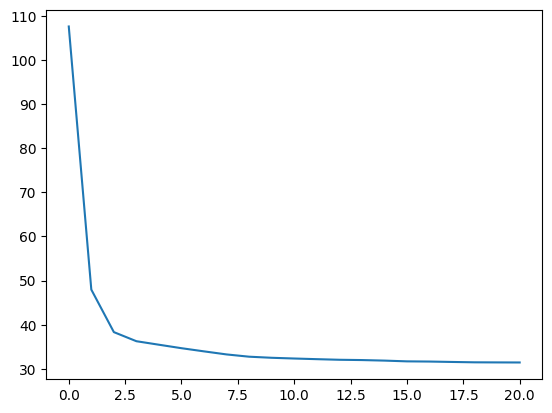

In [8]:
optimiser = JAYA_ELM(1000)
optimiser.optimise(20)
ec = optimiser.best_error_graph
plt.plot(ec)
preds_train = optimiser.forward_function(optimiser.weight[optimiser.best], optimiser.bias[optimiser.best], optimiser.beta[optimiser.best],  train_x)

In [9]:
print(preds_train.shape)
# print(np.array(train_y)[:, 0])
# print(np.array(preds_train)[:, 0])
error_train = (np.array(train_y)[:, 0] - np.array(preds_train)[:, 0])
# print(error_train)
print(np.mean((error_train) ** 2))

(655, 1)
0.0021033958006751595


In [10]:
preds = optimiser.forward_function(optimiser.weight[optimiser.best], optimiser.bias[optimiser.best], optimiser.beta[optimiser.best], test_x)
print(preds.shape)
error_test = (np.array(test_y)[:, 0] - np.array(preds)[:, 0])
print(np.mean(error_test ** 2))

(116, 1)
0.002787965132027284


In [11]:
np.array(preds)[:, 0]

array([0.1663423 , 0.16741678, 0.16579292, 0.16351679, 0.16526689,
       0.16762194, 0.16718529, 0.16908514, 0.17148709, 0.17169888,
       0.17304315, 0.17573104, 0.17597666, 0.17325069, 0.17359298,
       0.17296155, 0.16769506, 0.16651697, 0.16883219, 0.16956564,
       0.17049946, 0.17571984, 0.18076878, 0.18232103, 0.1861265 ,
       0.18989349, 0.19172202, 0.19515241, 0.20063508, 0.21669565,
       0.22747549, 0.24101451, 0.27015963, 0.27869276, 0.28806267,
       0.29098979, 0.28471063, 0.29255963, 0.28725773, 0.28032818,
       0.29464269, 0.29789536, 0.29468126, 0.29351783, 0.30761474,
       0.32261011, 0.32296109, 0.33714777, 0.33804209, 0.33209138,
       0.33535783, 0.3308384 , 0.32369626, 0.31420098, 0.3121521 ,
       0.30018493, 0.28957994, 0.2933544 , 0.28989982, 0.29479468,
       0.29830196, 0.29341077, 0.30418852, 0.31500425, 0.32456186,
       0.33528396, 0.35242174, 0.36124207, 0.36441221, 0.38072999,
       0.39285992, 0.41069481, 0.43179284, 0.45547435, 0.48909

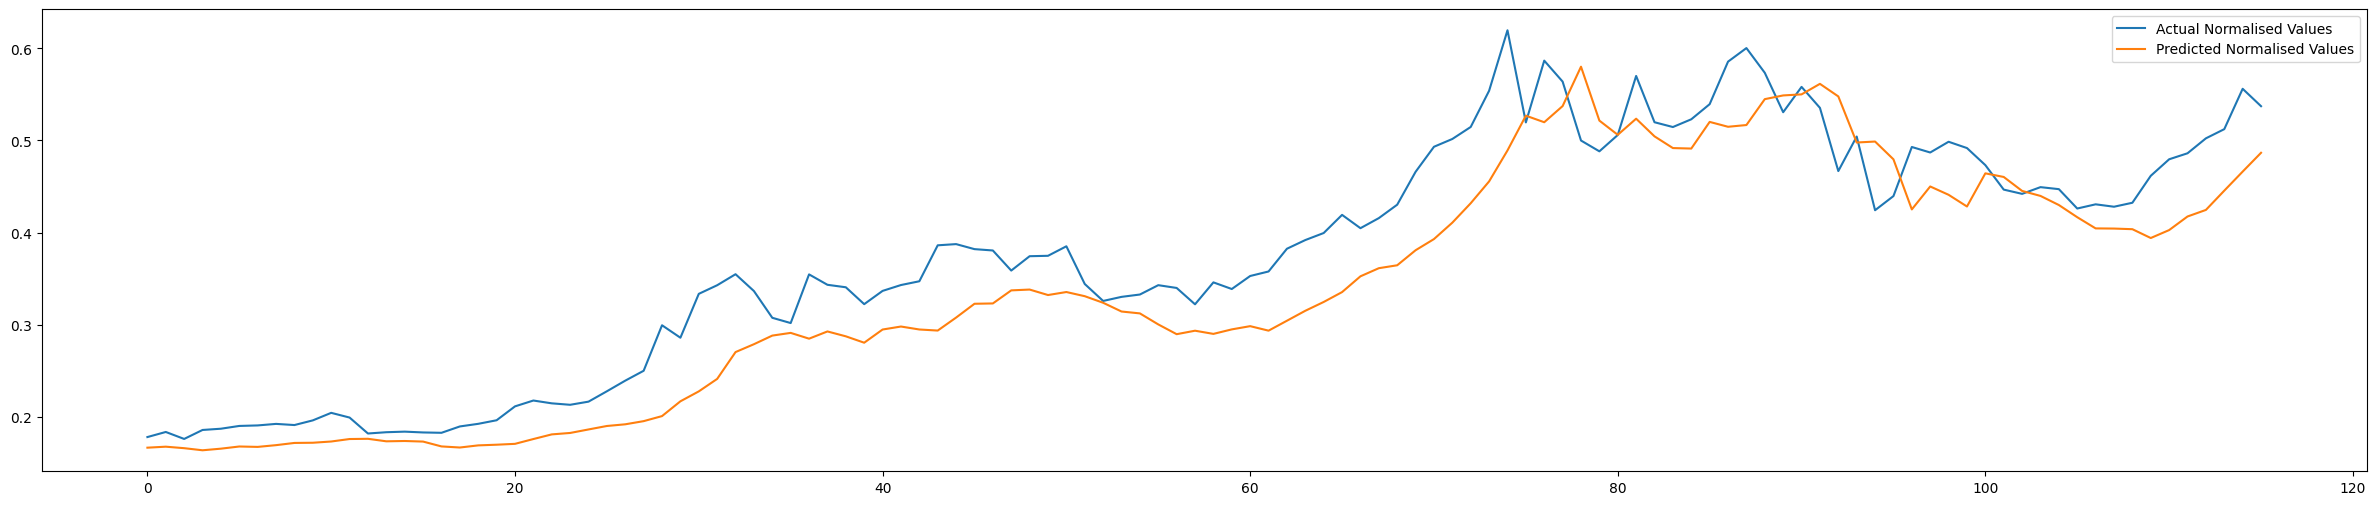

In [12]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(np.array(preds)[:, 0])
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [13]:
denormalized_preds = denormalize(preds)
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

                       0
DATE                    
2019-04-14   4861.730693
2019-04-15   4880.792206
2019-04-16   4851.984606
2019-04-17   4811.605419
2019-04-18   4842.652593
...                  ...
2019-08-03   9315.286807
2019-08-04   9441.721865
2019-08-05   9813.102878
2019-08-06  10180.011392
2019-08-07  10542.529589

[116 rows x 1 columns]


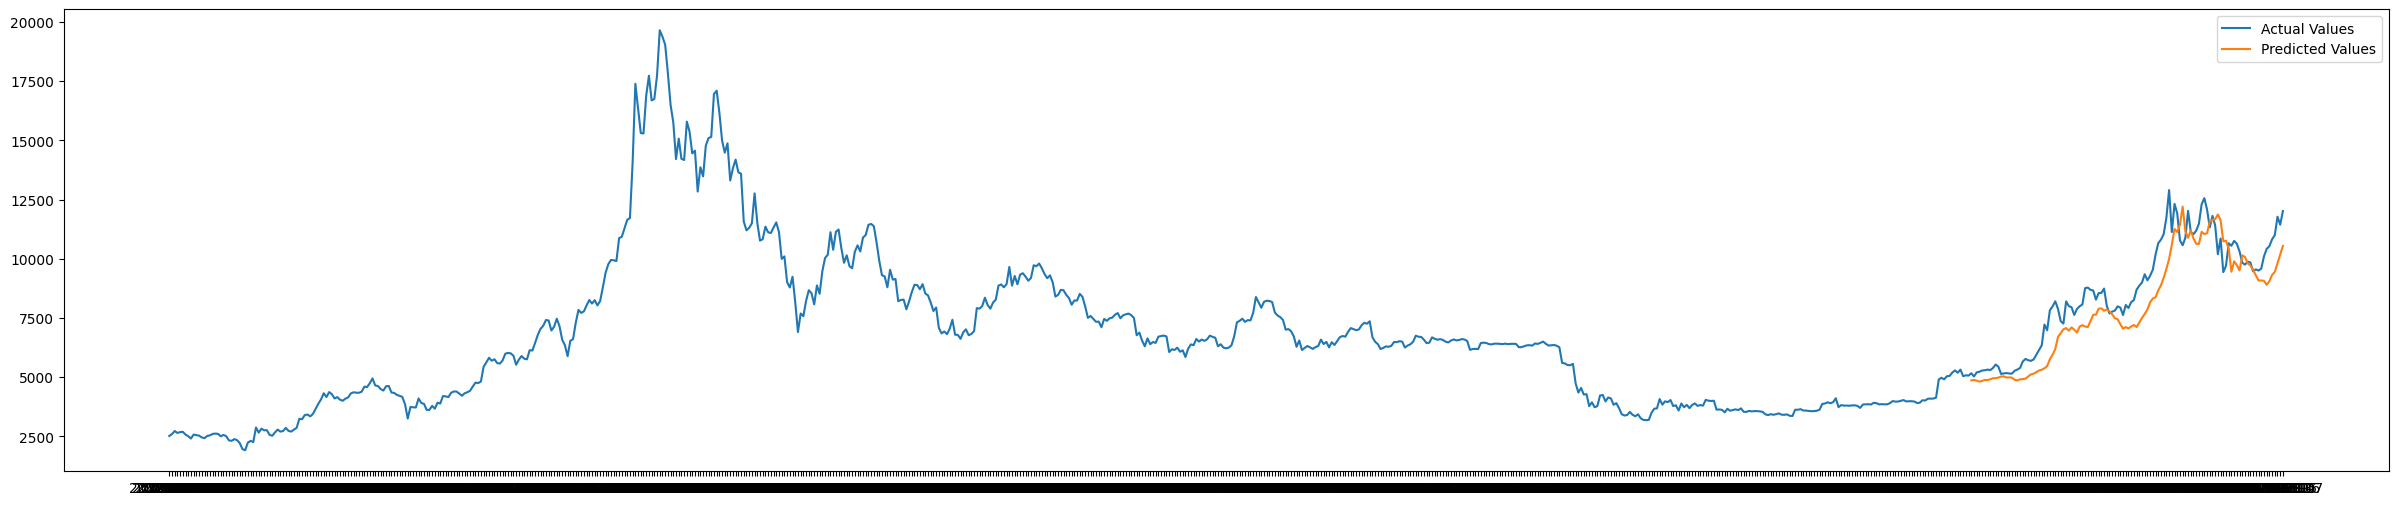

In [14]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [15]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  1128646.454773628
rmse 1062.3777363883469


In [16]:
(np.array(test_y) - np.array(preds))[:, 0]

array([ 0.01152687,  0.01597938,  0.010034  ,  0.02205691,  0.0216653 ,
        0.02232543,  0.02331844,  0.02308317,  0.019427  ,  0.02428618,
        0.03112388,  0.02331486,  0.00575887,  0.00987715,  0.01015999,
        0.00991206,  0.01479806,  0.02287799,  0.02340714,  0.02655527,
        0.04069397,  0.04182131,  0.03371998,  0.03059165,  0.03019933,
        0.0377039 ,  0.04741298,  0.05469553,  0.09863782,  0.06903796,
        0.10589955,  0.10171724,  0.0845449 ,  0.05772791,  0.01931271,
        0.01067597,  0.06980675,  0.05065801,  0.05326322,  0.04186042,
        0.04194821,  0.04505961,  0.05236216,  0.09256792,  0.07977989,
        0.05933082,  0.05751425,  0.02151669,  0.03621461,  0.0426067 ,
        0.0496648 ,  0.01325128,  0.00197483,  0.01590353,  0.02050255,
        0.04261728,  0.05020483,  0.02868539,  0.05594406,  0.04383791,
        0.05446855,  0.06426328,  0.07817406,  0.07679168,  0.07487885,
        0.08385886,  0.05226354,  0.05437881,  0.06578627,  0.08

In [17]:
err_test = (np.array(test_y) - np.array(preds))[:, 0]
mse_test = np.mean(err_test ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(err_test))
mape_test = np.mean(np.abs(err_test) / np.array(test_y)[:, 0])
EBPN = pd.DataFrame([[mse_test, rmse_test, mae_test, mape_test]], columns = ["mse", "rmse", "mae", "mape"], index = ['BPN'])
EBPN

,mse,rmse,mae,mape
BPN,0.002788,0.052801,0.044377,0.120585
